In [1]:
import lightgbm as lgbm
from hyperopt import hp, tpe, Trials

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocessing 
from utils.utils import feature_importances,initial_hyperparam_search,cast_params_to_proper_types,lgb_f1_score,feature_imp_lgbm

In [3]:
prepos= preprocessing()
df_credit_application = prepos.read_data("credit_applications.csv")
df_customers = prepos.read_data("customers.csv")
df_customers.drop("Unnamed: 0",axis=1,inplace=True)
df_credit_application.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
df_complete_data = df_customers.merge(df_credit_application,how="inner",on=["client_nr","yearmonth"])
print(df_complete_data.shape)

(29996, 12)


##### EDA And feature importances

In [5]:
df_complete_data.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications
count,29996.000000,29996.000000,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04,24459.000000,29996.000000,29996.000000
mean,481.560775,201493.675157,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06,3.251850,0.067509,0.087078
std,281.317753,77.361645,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07,1.889136,0.250906,0.364473
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08,1.000000,0.000000,0.000000
25%,237.000000,201409.000000,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06,2.000000,0.000000,0.000000
50%,479.000000,201505.000000,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06,3.000000,0.000000,0.000000
75%,721.000000,201601.000000,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06,4.000000,0.000000,0.000000
max,1000.000000,201608.000000,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08,7.000000,1.000000,7.000000


<Axes: xlabel='credit_application', ylabel='count'>

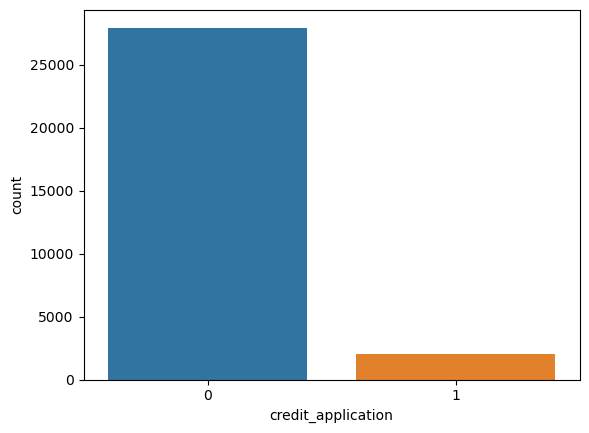

In [6]:
sns.countplot(x=df_complete_data["credit_application"])

# 0    27971
# 1     2025

In [7]:
prepos.missing_values_intable(df_complete_data)

,Missing Values,Percentage of missing values
client_nr,0,0.000000
yearmonth,0,0.000000
total_nr_trx,0,0.000000
nr_debit_trx,0,0.000000
volume_debit_trx,0,0.000000
nr_credit_trx,0,0.000000
volume_credit_trx,0,0.000000
min_balance,0,0.000000
max_balance,0,0.000000
CRG,5537,18.459128


In [8]:
# plt.rcParams["figure.figsize"] = [5,5]  #set the graph to a smaller size 
df_complete_data["debit_credit_ratio"]=df_complete_data["volume_debit_trx"]/df_complete_data["volume_credit_trx"]

In [9]:
df_complete_data["debit_credit_ratio"] = np.where(df_complete_data["debit_credit_ratio"]==np.inf,df_complete_data["volume_debit_trx"],df_complete_data["debit_credit_ratio"])

In [10]:
corl= df_complete_data.corr()
corl["credit_application"].sort_values(ascending=False)

credit_application        1.000000
nr_credit_applications    0.887960
CRG                       0.104958
nr_debit_trx              0.030467
client_nr                 0.020659
volume_credit_trx         0.013168
volume_debit_trx          0.008674
total_nr_trx             -0.001848
debit_credit_ratio       -0.002477
yearmonth                -0.011546
nr_credit_trx            -0.011643
max_balance              -0.043633
min_balance              -0.082577
Name: credit_application, dtype: float64

In [11]:
fimp=feature_importances()
X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
print(accepted_columns)
print(assoc_result["credit_application"].sort_values(ascending=False))

df_complete_data.drop("nr_credit_applications",axis=1,inplace=True)
fimp=feature_importances()
X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
print(accepted_columns)
print(assoc_result["credit_application"].sort_values(ascending=False))

Removing columns: []
['CRG', 'credit_application', 'nr_credit_applications']
credit_application        1.00
nr_credit_applications    0.89
CRG                       0.13
min_balance               0.08
max_balance               0.04
nr_debit_trx              0.03
client_nr                 0.02
yearmonth                 0.01
volume_debit_trx          0.01
nr_credit_trx             0.01
volume_credit_trx         0.01
total_nr_trx              0.00
debit_credit_ratio        0.00
Name: credit_application, dtype: float64
Removing columns: []
['min_balance', 'CRG', 'credit_application']
credit_application    1.00
CRG                   0.13
min_balance           0.08
max_balance           0.04
nr_debit_trx          0.03
client_nr             0.02
yearmonth             0.01
volume_debit_trx      0.01
nr_credit_trx         0.01
volume_credit_trx     0.01
total_nr_trx          0.00
debit_credit_ratio    0.00
Name: credit_application, dtype: float64


For a Time being delete rows where CRG is not present

In [12]:
df_complete_data[df_complete_data["CRG"].isna()]["credit_application"].value_counts()
# 0    5395
# 1     142

0    5395
1     142
Name: credit_application, dtype: int64

In [13]:
df_complete_data = df_complete_data[~df_complete_data["CRG"].isna()]

In [14]:
df_complete_data.shape

(24459, 12)

#### To do : Missing value treatment for CRG

In [15]:
df_complete_data.groupby(["client_nr","yearmonth","CRG"])["total_nr_trx"].count().reset_index()

,client_nr,yearmonth,CRG,total_nr_trx
0,1,201401,1.0,1
1,1,201402,1.0,1
2,1,201403,1.0,1
3,1,201404,1.0,1
4,1,201405,1.0,1
...,...,...,...,...
24454,988,201604,3.0,1
24455,988,201605,3.0,1
24456,988,201606,3.0,1
24457,988,201607,3.0,1


###### New features ideas
Calculate how many times client has applied for credit in the past for each month

In [18]:
def calculate_nr_credit_in_past(current_index):
#     print(current_index)
    client_nr = df_complete_data.loc[[current_index]]["client_nr"].values[0]
    tmp_sum = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].sum()
    tmp_cnt = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].count()
    if(tmp_cnt==0):
        return 0
    else:
        return tmp_sum/tmp_cnt

In [19]:
df_complete_data.to_csv("test_the feature.csv")

In [20]:
df_complete_data["credit_applied_before_ratio"]= df_complete_data.index.map(calculate_nr_credit_in_past)

#### Split data strategy

As part of train/test data split, 20% of data will be reserved as test data and will not seen by any model.
That amounts to approximately = 6 months worth of data.
Instead of splitting train/test data randomly, I decided to leave last 6 month data as test data set i.e. March 2016 to August 2016

In [21]:
X_test = df_complete_data[df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
y_test = X_test["credit_application"]

X_train_org = df_complete_data[~df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
y_train_org = X_train_org["credit_application"]

X_train,X_val,y_train,y_val=train_test_split(X_train_org,X_train_org["credit_application"],test_size=0.2,random_state=42,stratify=X_train_org["credit_application"])

X_test.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_train_org.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_train.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_val.drop(["credit_application","client_nr"],axis=1,inplace=True)


# X_test.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train_org.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_val.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)

##### 2. Using Lightgbm feature importance

In [22]:
from lightgbm import plot_importance
params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 5, 100, 5),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
                            }

In [23]:
model,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
                   'feature_importance':model.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

100%|██████████████████████████████████████████████| 250/250 [03:08<00:00,  1.33trial/s, best loss: 0.7487844408427877]


C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [24]:
initial_params

{'learning_rate': 0.016227953524961123,
 'max_bin': 144.0,
 'n_estimators': 140.0,
 'num_leaves': 8.0,
 'pos_bagging_fraction': 0.7086174181792493,
 'reg_lambda': 36.926912023728526,
 'scale_pos_weight': 10.0}

In [25]:
feature_imp_df

,feature_name,feature_importance
8,CRG,165
10,credit_applied_before_ratio,150
6,min_balance,137
0,yearmonth,97
2,nr_debit_trx,95
9,debit_credit_ratio,93
1,total_nr_trx,69
7,max_balance,51
4,nr_credit_trx,50
5,volume_credit_trx,39


In [77]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve

In [78]:
kfolds = StratifiedKFold(5)
current_f1_scores=[]
roc_auc_scores_val=[]
precision_score_val=[]
recall_score_val=[]
fpr_scores=[]
tpr_scores=[]
mean_roc_auc_scores_val = []
mean_precision_scores_val = []
mean_recall_scores_val = []
mean_f1_scores_val = []

In [79]:
for train_idx ,val_index in kfolds.split(X_train_org,y_train_org):
#     model = lgb.LGBMClassifier(
#                 verbose=-1,
#                 objective='binary',
#                 **initial_params
#             )
    model.fit(
                X_train_org.iloc[train_idx],
                y_train_org.iloc[train_idx],
#                 eval_set=[(X_train.iloc[val_index], y_train.iloc[val_index])],
                eval_metric=lgb_f1_score
            )
    y_pred=np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >0.4,1,0)
#     y_pred=model.predict(X_train_org.iloc[val_index])
    current_f1_scores.append(f1_score(y_train_org.iloc[val_index], y_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_org.iloc[val_index],y_pred).ravel()
    print(confusion_matrix(y_train_org.iloc[val_index],y_pred))
    roc_auc_scores_val.append(roc_auc_score(y_true=y_train_org.iloc[val_index], y_score=y_pred))
    precision_score_val.append(precision_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
    recall_score_val.append(recall_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
    fpr_val, tpr_val, _ = roc_curve(y_true=y_train_org.iloc[val_index], y_score=y_pred)
    fpr_scores.append(fpr_val)
    tpr_scores.append(tpr_val)
    
    

[[2299 1369]
 [  84  228]]
[[2183 1484]
 [ 107  205]]
[[2157 1510]
 [  88  224]]
[[1650 2017]
 [  71  241]]
[[1748 1919]
 [  57  255]]


In [80]:
def plot_roc(fpr,tpr,roc_auc,color_ip):
#     fpr,tpr,threshold=roc_curve(y_test,probs)
#     roc_auc=auc(fpr,tpr)
    print('ROC AUC=%0.2f'%roc_auc)
    plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc,color=color_ip)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 
#     plt.show()

ROC AUC=0.68
ROC AUC=0.63
ROC AUC=0.65
ROC AUC=0.61
ROC AUC=0.65
Mean ROC AUC score on validation data =0.64


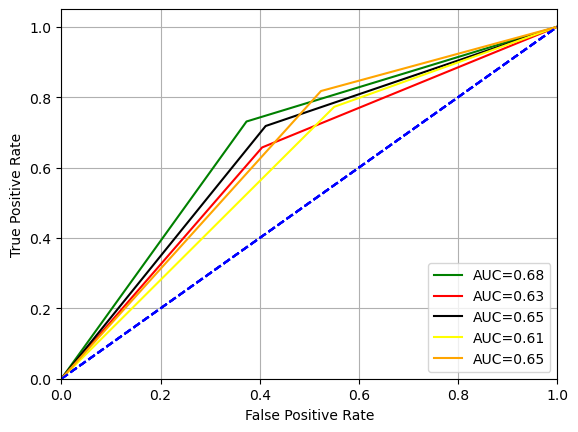

In [81]:
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [82]:
def print_metrics(f1_scores,recall_scores,precision_scores,dataset="validation"):
    print("F1 scores on "+ dataset+" data:")
    print(f1_scores)
    print("-----------------------------------------------------")
    print("Recall scores on "+ dataset+" data:")
    print(recall_scores)
    print("-----------------------------------------------------")
    print("Mean f1 score on "+ dataset+" data:")
    print(np.mean(f1_scores))

    print("-----------------------------------------------------")
    print("Mean recall score on "+ dataset+" data:")
    print(np.mean(recall_scores))

    print("-----------------------------------------------------")
    print("Mean precision score on "+ dataset+" data:")
    print(np.mean(precision_scores))

In [83]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.2388685175484547, 0.2048975512243878, 0.21896383186705765, 0.18754863813229575, 0.20514883346741752]
-----------------------------------------------------
Recall scores on validation data:
[0.7307692307692307, 0.657051282051282, 0.717948717948718, 0.7724358974358975, 0.8173076923076923]
-----------------------------------------------------
Mean f1 score on validation data:
0.21108547444792264
-----------------------------------------------------
Mean recall score on validation data:
0.739102564102564
-----------------------------------------------------
Mean precision score on validation data:
0.1234698593099361


In [38]:
model.predict_proba(X_train_org.iloc[val_index])[:,1]

array([0.26573828, 0.27271099, 0.27029568, ..., 0.09697456, 0.09521273,
       0.06225099])

In [98]:
y_pred = np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >0.48,1,0)
confusion_matrix(y_train_org.iloc[val_index],y_pred)

array([[2441, 1226],
       [ 128,  184]], dtype=int64)

0.3
0.35
0.4
0.45
0.5
0.55
0.61


In [114]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model.predict_proba(X_test)[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[2082 2158]
 [  52  271]]
F1 score on Test data:
0.19694767441860464
-----------------------------------------------------
Recall score on Test data:
0.8390092879256966
-----------------------------------------------------
Precision score on Test data:
0.11156854672704816
---------------THRESHOLD =0.35 ----------------------
[[2176 2064]
 [  56  267]]
F1 score on Test data:
0.20120572720422006
-----------------------------------------------------
Recall score on Test data:
0.826625386996904
-----------------------------------------------------
Precision score on Test data:
0.11454311454311454
---------------THRESHOLD =0.4 ----------------------
[[2454 1786]
 [  80  243]]
F1 score on Test data:
0.20663265306122447
-----------------------------------------------------
Recall score on Test data:
0.7523219814241486
-----------------------------------------------------
Precision score on Test data:
0.11976343026121242
---------------THRE

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


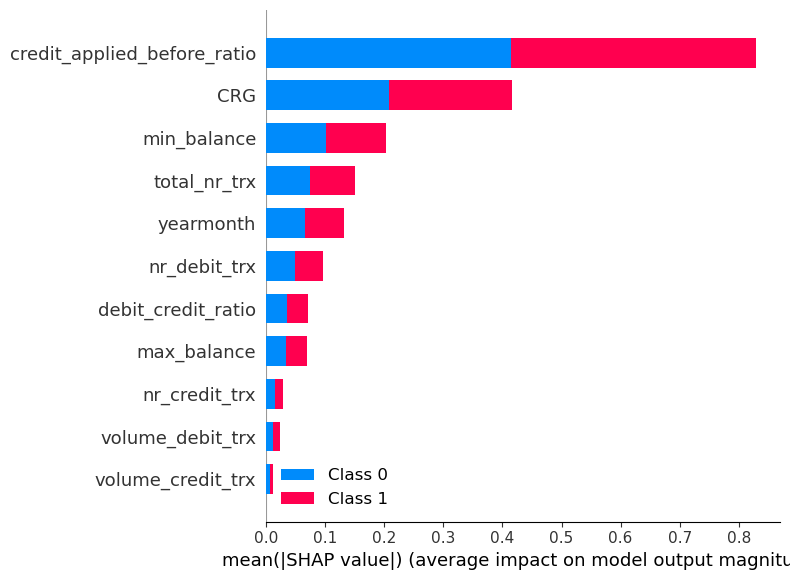

In [91]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")